# Navigation

---

This notebook is being used as an interactive report of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

This project seemed like a good candidate to be solved with DQN. I wanted to apply what I have learned so far and implement my own version (the code is based on the DQN implementation presented in the previous lesson). This has also helped me get more comfortable with Python, as I am C++ programmer.


## 1. Deep Q-Network

The Deep Q-Network algorithm, also known as DQN, is a well known Deep Reinforcement Learning algorithm. 

DQN is a value-based method that uses a Deep Neural Network to approximate the action-value function of the problem we are trying to solve. 

### Common issues in value-based deep-reinforcement learning

In a way, DQN does this by approaching the problem closer to what a supervised-learning solution would. However, value-based deep reinforcement learning presents two issues that differentiate both types of problems:

- **Data does not comply with the IID assumption**: 
In a supervised learning problem, we start with a full dataset that can be preprocessed before we feed it to our algorithm. This makes the different examples in the dataset be more independent and identically distributed [IID assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), which leads to benefits such as a faster convergence, and the possibility of getting more information out of our data.

In value-based drl, our samples are often obtained as our model is trained, which makes the experience at t+1 much more correlated to that at t.

- **Targets are non-stationary**
Supervised learning is performed with fixed targets coming from the dataset. But in a drl environment, those targets are potentially being generated with every training step. In other words, we are chasing a moving target. This can lead to divergence.

### Solving the non-compliance with the IID assumption

To help ease the problem of data-correlation, and also make sure that all of our experience can be used during training, DQN introduces the use of a **replay memory**.

Every new experience is stored in that memory (which is actually a FIFO buffer, i.e., the oldest experiences are discarded when the buffer is full), giving the agent a much richer range of experiences. The algorithm will work with mini-batches taken at random from the buffer, avoiding the sample-correlation problem and allowing for a more IID dataset.

Replay buffers can be difficult to implement depending on the problem that is being resolved, as they will tend to high memory usage, but in our case this is not a real problem.

### Solving the non-stationarity of targets

To separate calculations and work with more stationary targets, DQN uses a second, separate network (**target network**) that lags behind the network we are using to train (**local network**). The weights of the local network are copied onto the target network, but this process only happens every few steps (**hard update**); we could also interpolate the values to try and get closer to the online ones (**soft update**), which is the option we have selected for this project. Either option will effectively "lock" our targets in place during that time.

### Algorithm details

DQN works by approximating the action-value function Q(s,a,θ). It uses a state-in-values-out architecture, which means that the network has an input layer matching the size of the state, and an output layer with as many nodes as potential actions we have - the algorithm approximates the Q values for every action in one go. 

DQN uses off-policy TD targets (r + ɣ*max_a'Q(s', a'; θ')). As we have discussed, it will calculate those targets by using a second neural network that uses the same weights as the local (also known as 'online') one, but that only updates them every few steps, basically locking the targets in place for that duration.

Training uses a mini-batch of past experiences that is obtained from an experience memory.

```{r, tidy=FALSE, eval=FALSE, highlight=FALSE }

DQN optimization algorithm

1. Get current state
2. Select action to take from current state - we can use an epsilon-greedy strategy to allow for some exploration.
3. Get the Q estimate for the next state using the target network
4. Create TD targets as described earlier (r + ɣ*max_a'Q(s', a'; θ'))
5. Query the current online estimate
6. Calculate the loss and optimize the online network.
7. Update target network's weights as required
```

## Implementation

To improve readability, the code has been split into different files:
- [agent.py](agent.py)
- [replay_buffer.py](replay_buffer.py)
- [model.py](model.py)

These files are commented to help make that code self-explanatory.



### Initializing the environment

The first step would be to start our Unity environment. The next cell will do this for you, but you will need to make sure the correct executable for your environment is present and that the *path_to_env* constant points to that. 

We will as well get the default brain from the environment, as we will need that later on to run the actions on the agent. We will also import all of the libraries required to run this code.

In [1]:
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from agent import Agent
from unityagents import UnityEnvironment
import numpy as np
import torch

path_to_env = "Banana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=path_to_env)

# Device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

This information (particularly, the size of the state space and the number of actions) is required to initialize our agent, which we will do in the next cell.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

#initialize the agent
myAgent = Agent(state_size, action_size, 0, device)

### Training the agent

Once our environment is initialized, we can start training our agent. The function below (*train_agent*) will run this process. We are considering the problem as solved when the average score in the last 100 steps has been >= 13. When our agent hits this, we will save the weights in our now trained online network, so we can re-use them later when testing our agent.


In [3]:
def train_agent(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    # For as many episodes as requested...
    for i_episode in range(1, n_episodes + 1):
        
        # Reset the environment, since we're just starting a new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Do the same with the accumulated score...
        score = 0
        
        # ... and get our initial state
        state = env_info.vector_observations[0]
        
        # For as many time steps we want to run...
        for t in range(max_t):
            
            # Calculate an action
            action = myAgent.act(state, eps).astype(int)
            
            # Get state, reward, etc. after the execution of that action
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # Pass the information of this experience up to the Agent
            myAgent.step(state, action, reward, next_state, done)
            
            # Update accumulated score
            score += reward
            
            # Update state to use
            state = next_state
            
            if done:
                break
        
        # When we're done with this episode, we'll store the scores and decide if we've resolved the problem
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
       
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        min_score_for_solved = 13.0
        if np.mean(scores_window) >= min_score_for_solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            # Environment has been solved, so save the weights of the local network
            oldState = myAgent.qnetwork_local.state_dict()
            torch.save(oldState, 'trained_results.pth')
            break
    
    return scores
            
    
# First, train our agent    
scores = train_agent()

Episode 100	Average Score: 1.13
Episode 200	Average Score: 4.53
Episode 300	Average Score: 8.06
Episode 400	Average Score: 9.72
Episode 500	Average Score: 12.75
Episode 523	Average Score: 13.03
Environment solved in 423 episodes!	Average Score: 13.03


<function matplotlib.pyplot.show(close=None, block=None)>

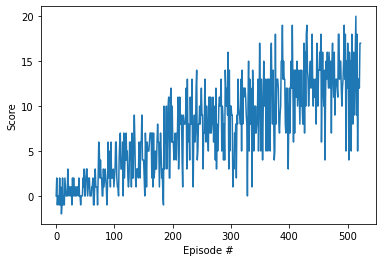

In [4]:
# Then, plot the scores obtained per episode we've run
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show

We can also see what the results of our training look like on an agent. For this, all we need to do is to reload the results we had previously saved into the local network (so it starts directly from the state the training left it at). After that, we can get our agent to act using its policy and just observe how it behaves. We will not run the environment in train_mode this time.

In [5]:
newState = torch.load('trained_results.pth')
myAgent.qnetwork_local.load_state_dict(newState)

episode_count = 5
for i in range(episode_count):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]

    score = 0
    while True:
        action = myAgent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        
        reward = env_info.rewards[0]
        score += reward
        
        done = env_info.local_done[0]
        
        #update state
        state = env_info.vector_observations[0]

        if done:
            break
            
    # Print the score achieve by the agent during this episode
    print("Score: ", score)

Score:  21.0
Score:  20.0
Score:  22.0
Score:  18.0
Score:  17.0


Finally, we just need to close the environment once we are done experimenting with it.

In [6]:
env.close()

## Ideas for future work

The first thing we could try to improve our solution is to study the effects of the different hyperparameters on the results we obtain. Could we use more hidden layers? Larger or shorter ones? Are our epsilon, tau, gamma, etc. correct, or can we choose something better.

Secondly, we could attack the solution itself. DQN has received several improvements over the years. The original algorithm was introduced in 2013 and it only included the concept of *replay memory*. Later, in 2015, a second paper was published that added the use of a target network.

Over the years, new improvements have been introduced, solving some of the problems of the original approach, which has made vanilla DQN not be considered state-of-the-art anymore. As future work, we could explore implement some of these enhanced algorithms.

The first one we would tackle is DDQN (double deep Q-networks). DQN shows a positive bias (which affects performance negatively) due to the use of max estimate values. DDQN addresses this problem.

After DDQN, we could try to introduce Dueling DDQN, which does not change the algorithm, but modifies the architecture of the network.

It would be interesting to compare the performance and results of all these different approaches and try to understand what changes are presented and why a version could be preferable over another.
